# Introduction

For the task of Early Prediction of Sepsis from Clinical Data, we were given demographic and medical data collected from patients during their stay at the hospital.

The data was recorded at an hourly rate, resulting in different lengths of dataframe, depending on the length of stay of the patients in the hospital.

Each record of the patient included the values measured, along a label indicating if the patient was diagnosed with sepsis in the upcoming 6 hours after the measurements were taken, or not.

Our goal was to predict the appearance of sepis in each patient, 6 hours before the formal diagnostic of sepsis.

When tackeling this problem, we explored two main directions:

- Sequence based models: Treating each patient as a sequence of data measurements, and applying sequence labeling models to try and predict whether a given patient is diagnosed with sepsis or not. 


- Aggregation based models: Summarizing all the data collected from the patient to a single vector, and applying classification models to try and predict whether a given patient is diagnosed with sepsis or not. 

The label of each patient's sequnece data or aggragated vactor was positive if at least one record of the patient's data was positive for sepsis.

The best performing model was an aggregation based model, which extracted four numerical metrics for each feature column: Mean, Std, Min and Max values.

Through these four metrics, we were able to represent to some extent the feature's distribution of each patient, and consequently allow us to succesfully predict for a given new patient data, if it has sepsis or not.

# Preliminary Research

Due to the lack of prior knowledge regarding Sepsis, we decided to perform preliminary research regarding the sickness' common symptoms.
We hoped that the research will aid us in the task of deciding which features to use, and in obtaining a better understanding of the data in hand.
Our research has led to the following conclusions:

<u> **Sepsis Common Symptoms:** </u>

- Heart Rate (HR) > 90 beats per minute.

- Respiration Rate (Resp) > 22 breaths per minute.

- White Blood Cell Count (WBC): very high or very low (normal range: [4.5, 11]).

- Temperature (Temp) > 38.3333 or Temperature < 36.

- Systolic Blood Pressure (SBP) $\leq$ 100.

- Lactic acid (Lactate) > 19.8.


In [1]:
import os
import warnings
warnings.filterwarnings("ignore")

# data loading and pre-processing
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

# statistical analysis
from scipy.stats import ks_2samp

# model fitting
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split

# model evaluation
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, roc_auc_score

# data visualization
import matplotlib.pyplot as plt ## needed to be downloaded
import seaborn as sns

# model saving
import pickle

In [2]:
test_path="/home/student/data/test"
train_path="/home/student/data/train"
home_path="/home/student"

test_set = os.listdir(test_path)
train_set = os.listdir(train_path)

# Exploratory Data Analysis

As previously stated, the data consists of demographic and medical information collected on each patient.
There are 3 types of features available in the dataset:


- **Vital Signs:** Crucial medical signs that indicate the status of the body’s vital functions. These features consist of the first 8 columns of the data-set, and include - inter alia - the patient's  Heart Rate, Temperture, Diastolic Blood Pressure.


- **Laboratory Values:** Laboratory values that are used to determine a patient’s overall health and well-being. These features appear in columns 9-34 of the data-set, and include - inter alia - the patient's  Glucose, Lactate and Magnesium levels.


- **Demographics:** Identification of a patient and his categorization into categories for the purpose of statistical analysis. These features consist of the last 6 columns of the data-set, and include - inter alia - the patient's Age, Gender and ICU Length of Stay.


**Outcome:** Finaly, each row of collected data has a column named **SepsisLabel**, which indicates if the patient in question was diagnosed with sepis within 6 hours of the data being collected. 

In the EDA section, we will look to compare the features' distribution on patients diagnosed positive or negative for sepsis, before and after the time of diagnosis.

To accomplish this, we united all the patient's data to a large file, with the addition of two new columns:

- **PatientId:** The unique file name of the patient's data.


- **PatientLabel:** A label identifying if the patient was diagnosed with sepsis or not, along the entire hospital stay.



In [3]:
sample_patient = pd.read_csv(os.path.join(train_path,train_set[0]),sep='|')
vitals = sample_patient.columns.to_list()[:8]
laboratory = sample_patient.columns.to_list()[8:34]
demographics = sample_patient.columns.to_list()[34:40]
features=vitals+laboratory+demographics
sepsis_label = 'SepsisLabel'

In [4]:
def unite_patients(file_name,set_name,path):
    patients_dfs=[]
    for patient_file in set_name:
        patient_df = pd.read_csv(os.path.join(path,patient_file), sep='|')
        patient_label=1 if 1 in patient_df[sepsis_label].unique() else 0
        patient_df['PatientLabel']=patient_label
        patient_df['PatientId']=patient_file.split(".",1)[0]
        patients_dfs.append(patient_df)
        
    united_df = pd.concat(patients_dfs,ignore_index=True)
    united_df.to_csv(file_name+".psv", sep='|',index=False)
    
unite_patients("training_set",train_set,train_path)

In [5]:
united_data=pd.read_csv("training_set.psv", sep='|')

## Imbalanced Data-Set

When considering label imbalance in the dataset, we account for two different labels:
- SepsisLabel: The label as defined in the dataset, which identifies if the record was taken 6 hours prior to the sepsis detection or not.


- PatientLabel: A label identifying if the patient was diagnosed with sepsis or not, along the entire hospital stay.

As we can see from the cells below, the data is highly imbalanced, when considering both the labels.

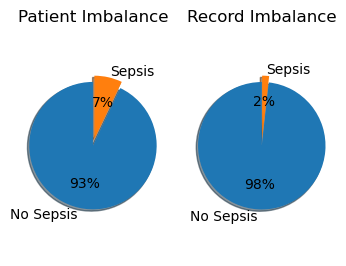

In [6]:
patient_labeling=united_data.groupby('PatientId').first()['PatientLabel'].value_counts()
record_labeling=united_data['SepsisLabel'].value_counts()

patient_pct=patient_labeling[1]/len(train_set)
record_pct=record_labeling[1]/len(united_data)

labels = 'No Sepsis', 'Sepsis'
explode = (0, 0.1)
fig = plt.figure(figsize=(4,3),dpi=100)
ax1 = fig.add_subplot(121)
ax1.pie([1-patient_pct, patient_pct], explode = explode, labels = labels, autopct = '%1.0f%%', shadow=True, startangle = 90)
ax1.axis('equal')
ax1.set_title("Patient Imbalance")

ax2 = fig.add_subplot(122)
ax2.pie([1-record_pct, record_pct], explode = explode, labels = labels, autopct = '%1.0f%%', shadow=True, startangle = 90)
ax2.axis('equal')
ax2.set_title("Record Imbalance")

plt.show()

## Missing Data

Upon first inspection of the data in hand, we can see that it is scarce to a certain extent.
When checking the Nan values in each column among the entire training-set, we can see that whilst the **Vital Signs**  are monitored relativelly consistently, the **Laboratory Values** are more sparse - averaging above 90% of missing values among the patients.

I.e., while the **Vital Signs** are monitored quite frequently, the **Laboratory Values** are not regualrly tracked.

This observation does make sense, as health care teams probably give more attention to a patient's vital signs during the patient's stay at the hospital.

Regarding the **Demographic** features, we can see that besides the identifier of the unit of stay of the patient, all of the features are present for all the patients.


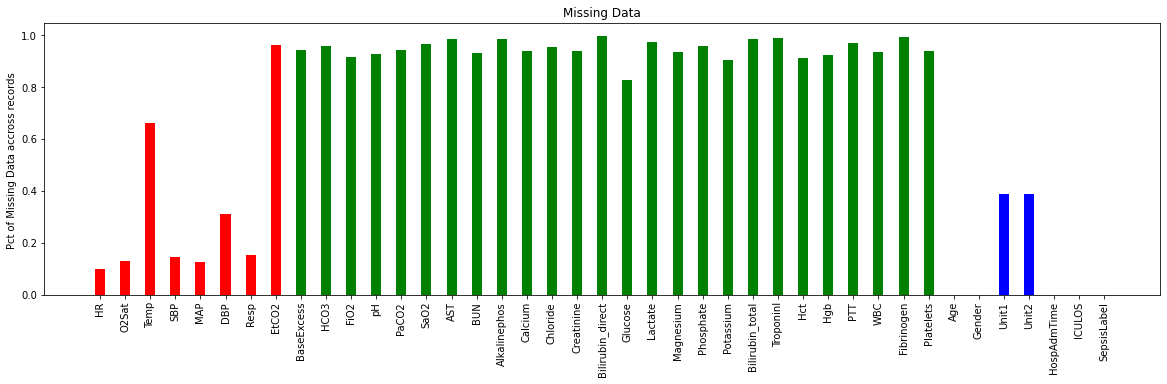

The per-patient average percentage of Nan values in the Vital Signs features is 0.334
The per-patient average percentage of Nan values in the Laboratory Values features is 0.949
The per-patient average percentage of Nan values in the Demographics features is 0.128


In [7]:
missing=united_data.iloc[:,:-2].isna().mean()

fig = plt.figure(figsize = (20, 5))
bars_list=plt.bar(range(len(missing.values)),missing.values, color =['r']*8+['g']*26+['b']*6,width = 0.4)
plt.xticks(range(len(missing.values)),missing.index,rotation=90)

plt.ylabel("Pct of Missing Data accross records ")
plt.title("Missing Data")
plt.show()

vitals_pct=united_data[vitals].isnull().groupby(united_data['PatientId']).mean().mean().mean()
laboratory_pct=united_data[laboratory].isnull().groupby(united_data['PatientId']).mean().mean().mean()
demographics_pct=united_data[demographics].isnull().groupby(united_data['PatientId']).mean().mean().mean()

print(f'The per-patient average percentage of Nan values in the Vital Signs features is {vitals_pct:.3f}')
print(f'The per-patient average percentage of Nan values in the Laboratory Values features is {laboratory_pct:.3f}')
print(f'The per-patient average percentage of Nan values in the Demographics features is {demographics_pct:.3f}')

## Feature Correlation

Our first step is to check for correlation between the different features.
This simple numeric metric will allow us to tell if there exists a linear relationship between the features, and allow us to identify at first glance if there might be pairs of features which are redundent. 
If a pair of features have high correlation- perhaps one of them will be redundent in the final prediction model.

In the heatmap below, we can see that for the most part, the feature columns are not highly correlated.

That being said, there are four pairs which seem to be highly correlated: 

- Bilirubin Direct and Total - Both parameters regard for Bilirubin compound. 
- MAP and DBP - Both parameters regard for blood pressure.
- HC03 and BaseExcess - Both parameters regard for Biocarbonate level.
- Hgb and Hct - Both parameters regard for red blood cell measurements.


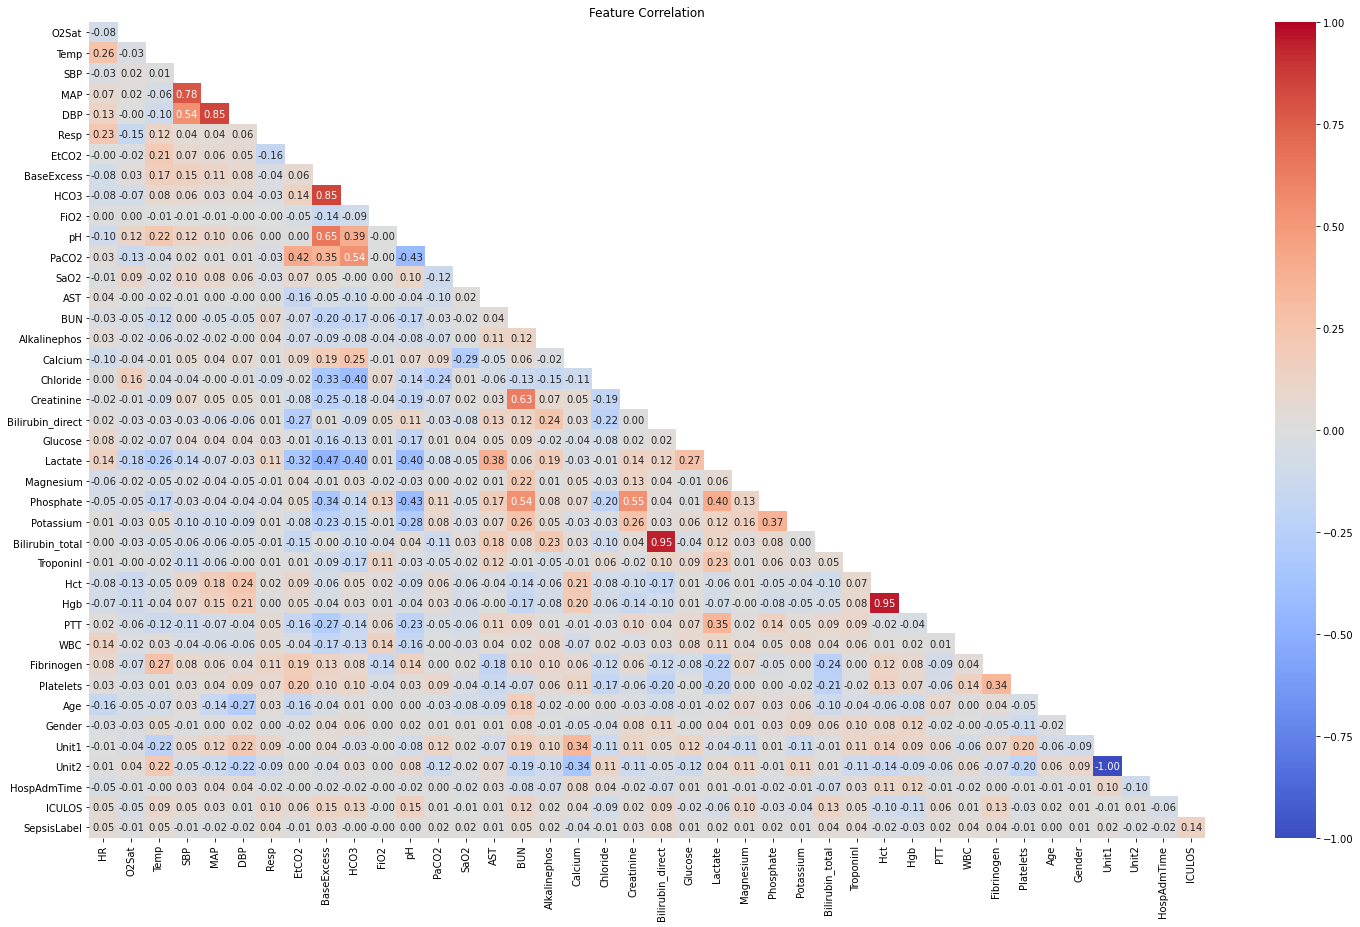

In [8]:
corr_matrix=united_data.iloc[:,:-2].corr()
fig, ax = plt.subplots(figsize=(25, 15))
mask = np.triu(np.ones_like(corr_matrix, dtype=np.bool))
mask = mask[1:, :-1]
corr = corr_matrix.iloc[1:,:-1].copy()
sns.heatmap(corr, mask=mask, annot=True, fmt=".2f", cmap='coolwarm',vmin=-1, vmax=1)
plt.yticks(rotation=0)
plt.title("Feature Correlation")
plt.show()

## Feature Distribution

Another way of assessing the potential effect of each feature in the classification model is to compare it's distribution over patients positive and negative for sepsis.

By comparing a feature's BoxPlot in the two groups, we can see if there exists first indication for difference in distribution.

Firstly, we can see that each feature's distribution under the two groups of SepsisLabel does not appear to be very different at first glance. Thus, we will need to use further  testing to see if there exists a statistical difference.

Secondly, we can see that the distributions themselves are highly contained with outliers

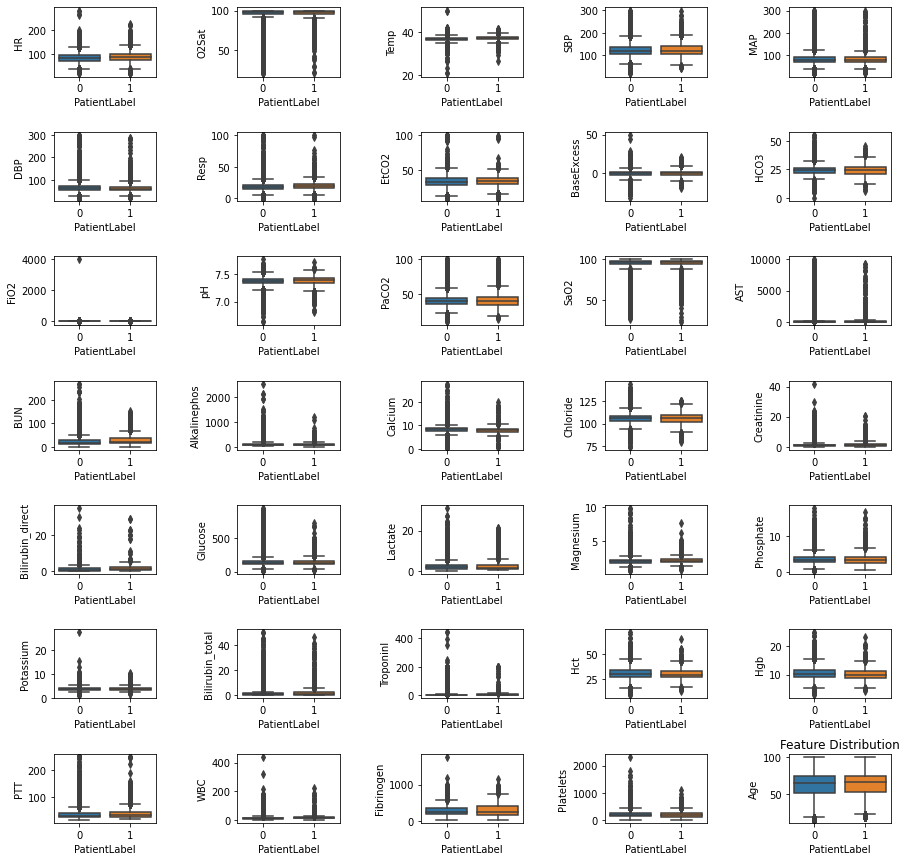

In [9]:
fig, axes = plt.subplots(7,5,figsize=(15, 15))
for i,ax in enumerate(axes.flat):
    sns.boxplot(y=features[i], x= 'PatientLabel', data=united_data, ax=axes.flat[i])

plt.subplots_adjust(wspace=0.8, hspace=0.8)
plt.title("Feature Distribution")
plt.show()

## Hypothesis Testing

As a direct result of the observations in the previous section, in this section, we performed statistical hypothesis testing considering two ways of partitioning the data in hand- partitioning by SepsisLabel, and partitioning by PatientLabel.
The partitioning by SepsisLabel would allow us to examine the distribution of features before and after the detection of sepsis, whilst the partitioning by PatientLabel would allow us to examine the distribution of features in healthy and sick patients, regardless of the time of monitoring.

We wish to test if there is significant statistical evidence to assume that certain features distribute differently under each group.

Thus, we will perform a Two sampled Kolmogorov-Smirnov test for goodness of fit: “The Kolmogorov–Smirnov statistic quantifies a distance between the empirical distribution function of the sample and the cumulative distribution function of the reference distribution, or between the empirical distribution functions of two samples.” (Wikipedia)


The formal formulation of the hypotheses is as follows: 
- $H_{0}$: The two distributions are identical, F(x)=G(x) for all x;
- $H_{1}$: The two distributions are not identical;

If there exists a significant statistical evidence that a feature's distribution among the two groups is the same, perhaps it will be redundent to the prediction model in the future.

Due to space limitations, we only outputed the features where the Null hypothesis was accepted under each model.

In [10]:
def test_hypothesis(label_feature,alpha):
    hypotheis_df=pd.DataFrame(columns=['Pval','Conclusion'])
    for feature in features:
        
        healthy=united_data[united_data[label_feature]==0][feature]
        sick=united_data[united_data[label_feature]==1][feature]
        
        _,pval = ks_2samp(healthy,sick,alternative='two-sided',mode='auto')
        conclusion="Reject H0" if pval<alpha else "Accept H0"
        hypotheis_df = hypotheis_df.append(pd.Series([pval,conclusion],index=['Pval','Conclusion'], name=feature))
            
        
    return hypotheis_df

In [11]:
print("Hypothesis testing for SepsisLabel")
res1=test_hypothesis('SepsisLabel',0.05)
display(res1[res1['Pval']>0.05])

print("Hypothesis testing for PatientLabel")
res2=test_hypothesis('PatientLabel',0.05)
display(res2[res2['Pval']>0.05])

Hypothesis testing for SepsisLabel


,Pval,Conclusion
Bilirubin_direct,0.999977,Accept H0
Glucose,0.143906,Accept H0
TroponinI,1.000000,Accept H0
Fibrinogen,0.955905,Accept H0


Hypothesis testing for PatientLabel


,Pval,Conclusion
Bilirubin_direct,1.000000,Accept H0
Bilirubin_total,0.147282,Accept H0
TroponinI,0.536896,Accept H0
Fibrinogen,0.391795,Accept H0


# Feature Engineering

## Feature Selection

In this section we tested 3 approaches for Feature Selection:

- EDA Based Feature Selection: After the EDA section, we had a few initial ideas as to which features could be excluded from the model when considering the results of the hypothesis testing or correlation testing performed. 

    Based on the correlation testing- we decided to drop one of the features from each pair with correlation larger than a certain (hyperparameter) threshold $\alpha$ (with the exception of the unit1 and unit2 features).

    Based on the hypothesis testing- we decided to drop features which their null hypothesis was accepted by both tests.


- Algorithmic Based Feature Selection: Sklearn's VarianceThreshold, SelectKBest and SelectFromModel.


- We finally tested the model which utilized the entire feature set.

Our best performing method of Feature Selection was the first one, with  $\alpha=0.95$, which resulted in the dropping of Bilirubin_direct, TroponinI, Fibrinogen and Hgb. 


## Feature Transformation

As stated before, the feature transformation performed included the calculation of the Mean, Std, Min and Max values for each feature, and using them to represent the feature's distribution on the given patient. The patient aggregated vector consisted of the concatenation of the feature's metrics among all available features.

## Handling Missing Data

Since we chose to use metrics which describe the distribution of a given feature in a each patient, we did not see any need in the imputation of missing data. Instead, we calculated each metric using the available data we had for each column, disregarding Nan values in the calculations. In the case of an entire column being absent in a given patient's data, thus implying the four metrics are undefined, we replaced each of them with a padding value chosen to be -1.

Several data imputations were tested just in case - Sklearns Mean-Imputation and Iterative-Imputation, and proved to be inefficient and failed to improve results obtained without data imputation.

In [4]:
# changing the threshold for the correlation
REMOVED_FEATURES = ['Bilirubin_direct', 'TroponinI', 'Fibrinogen', 'Hgb']

In [5]:
def crop_df(patient_df):
    """
    Crop the input df to contain only rows upto (and including) the first tow with SepsisLabel=1.
    If no such row, return the patient_df as is.
    """
    if 1 in patient_df[sepsis_label].unique():
        first_row_sepsis = patient_df[patient_df[sepsis_label] == 1].iloc[0].name
        return patient_df.iloc[:first_row_sepsis + 1]
    return patient_df

In [6]:
def feature_agg(patient_df):
    """
    Aggregate the input patient_df as described.
    For each column (besides the label column), calculate the Mean, Std, Min and Max
    Return Series containing the new values.
    """
    patient_df = patient_df.drop([sepsis_label], axis=1)
    mean=patient_df.mean().to_numpy()
    std=patient_df.std(ddof=0).to_numpy()
    mins=patient_df.min().to_numpy()
    maxs=patient_df.max().to_numpy()
    
    patient_vector=np.concatenate((mean,std,mins,maxs), axis=0)
    patient_series=pd.Series(patient_vector).fillna(-1)
    
    return patient_series

In [7]:
def aggregate_dataset(data_path, data_set, agg_method):
    """
    Aggregate the given data-set using the given aggregation method.
    For each patient in the data-set, create an aggregation vector, and construct a df out of all the patients.
    Save the new df to a psv file.
    """
    
    agg_df = pd.DataFrame()
    
    for patient_file in os.listdir(data_path):
        patient_df = pd.read_csv(os.path.join(data_path,patient_file), sep='|')
        patient_df = patient_df.drop(REMOVED_FEATURES,axis=1)
        patient_df=crop_df(patient_df)        
        patient_series=agg_method(patient_df)
        is_sick=1 if 1 in patient_df[sepsis_label].unique() else 0
        patient_series['PatientLabel']=is_sick
        
        agg_df = agg_df.append(patient_series, ignore_index=True)
        
        
    agg_df.to_csv(home_path + "/" + agg_method.__name__+"_"+data_set+'.psv', sep='|',index=False) 
        

In [16]:
aggregate_dataset(train_path,"train",feature_agg)

In [17]:
aggregate_dataset(test_path,"test",feature_agg)

In [8]:
aggregated_train=pd.read_csv("feature_agg_train.psv",sep="|")
aggregated_test=pd.read_csv("feature_agg_test.psv",sep="|")

# Prediction
For the submission, we decided to include two aggregated models:

- Logistic Regression classifier model as baseline.

- Random Forest classifier model as the main submitted model.

For both models, the hyperparameters are specified in the appropriate dictionary used to initiate the classifier.
All values besides the ones specified are set to the default value defined by Sklearn.
For both models, the values of these hyperparameters were selected by a trial and error process.

In both models,an appropriate class weight was assigned in order to overcome the label imbalance. Each class' weight factor   was inversly-proportional to the class percentage in the data-set.


In [9]:
X, Y = aggregated_train.loc[:, aggregated_train.columns != 'PatientLabel'], aggregated_train['PatientLabel']
X_train, X_val, Y_train, Y_val = train_test_split(X,Y,train_size=0.8, stratify=Y,random_state=42)

X_test, Y_test= aggregated_test.loc[:, aggregated_test.columns != 'PatientLabel'], aggregated_test['PatientLabel']

sepsis_pct = Y_train.value_counts()[1] / len(Y_train)

In [10]:
def print_stats(values,preds,probas):
    print(f"F1 score {f1_score(values, preds, average='binary')}")
    print(f"Precision score {precision_score(values, preds, average='binary')}")
    print(f"Recall score {recall_score(values, preds, average='binary')}")
    print(f"Accuracy score {accuracy_score(values, preds)}")
    print(f"ROC-AUC score {roc_auc_score(values, probas)}")

## Sklearn's Logistic Regression


Sklearn's implementation of Logistic Regression includes regularization appliance by default. The solver chosen, newton_cg , utilizes L2 regularization.

In addition to the classification model, we normalized the data column-wise. Whilst logistic regression does not neccesarily require normalized data, the solver's convergence time does benefit from it. 

In [23]:
lr_params = {
    "C" : 1, 
    "max_iter" : 1000, 
    "penalty" : "l2", 
    "random_state" : 42,
    "solver" : "newton-cg",
    "class_weight" : {1 : 1/sepsis_pct, 0 : 1/(1-sepsis_pct)}
}
print("Initiating LR model with:")
print(lr_params)
print()
lr=make_pipeline(StandardScaler(),LogisticRegression(**lr_params))
lr.fit(X_train, Y_train)

preds_lr = lr.predict(X_val)
print(f'Validation set scores of the model is:')
print_stats(Y_val,preds_lr,lr.predict_proba(X_val)[:, 1])
print()
preds_lr = lr.predict(X_test)
print(f'Test set scores of the model is:')
print_stats(Y_test,preds_lr,lr.predict_proba(X_test)[:, 1])

Initiating LR model with:
{'C': 1, 'max_iter': 1000, 'penalty': 'l2', 'random_state': 42, 'solver': 'newton-cg', 'class_weight': {1: 14.13427561837456, 0: 1.0761366693570082}}

Validation set scores of the model is:
F1 score 0.35384615384615387
Precision score 0.23337091319052988
Recall score 0.7314487632508834
Accuracy score 0.811
ROC-AUC score 0.8596069439334696

Test set scores of the model is:
F1 score 0.3735408560311284
Precision score 0.25311601150527324
Recall score 0.7125506072874493
Accuracy score 0.8229
ROC-AUC score 0.85563712383137


In [24]:
# train the same exact model, but on the entire training data available - save the statedict
lr=make_pipeline(StandardScaler(),LogisticRegression(**lr_params))
lr.fit(X, Y)
joblib.dump(lr[0], 'LR_Scaler.joblib')
joblib.dump(lr[1], 'LR_Classifier.joblib')
preds_lr = lr.predict(X_test)
print(f'Test set scores of the model is:')
print_stats(Y_test,preds_lr,lr.predict_proba(X_test)[:, 1])

Test set scores of the model is:
F1 score 0.37433534207727753
Precision score 0.25384615384615383
Recall score 0.7125506072874493
Accuracy score 0.8235
ROC-AUC score 0.8569490472049007


## Sklearn's Random Forest Classifier
For the Random Forest Classifier, no regularization was used.

Contrary to the Logistic Regression model, we did not include standardization to the data. Since Random Forest is tree-based, it utilizes metrics such as Gini Index, Entropy or Information Gain. These metrics are not effected by scaling, unlike distance metrics, and thus standardization is not mandatory.  

In [12]:
rfc_params = {
    'n_estimators':300,
    'max_depth':9,
    'random_state': 42,
    "class_weight" : {1 : 1/sepsis_pct, 0 : 1/(1-sepsis_pct)}
}
print("Initiating RFC model with:")
print(rfc_params)
print()
rfc=make_pipeline(RandomForestClassifier(**rfc_params))
rfc.fit(X_train, Y_train)

preds_rfc = rfc.predict(X_val)
print(f'Validation set scores of the model is:')
print_stats(Y_val,preds_rfc,rfc.predict_proba(X_val)[:, 1])
print()
preds_rfc = rfc.predict(X_test)
print(f'Test set scores of the model is:')
print_stats(Y_test,preds_rfc,rfc.predict_proba(X_test)[:, 1])

Initiating RFC model with:
{'n_estimators': 300, 'max_depth': 9, 'random_state': 42, 'class_weight': {1: 14.13427561837456, 0: 1.0761366693570082}}

Validation set scores of the model is:
F1 score 0.7215686274509804
Precision score 0.8105726872246696
Recall score 0.6501766784452296
Accuracy score 0.9645
ROC-AUC score 0.9259395519202671

Test set scores of the model is:
F1 score 0.7094339622641509
Precision score 0.8047945205479452
Recall score 0.6342780026990553
Accuracy score 0.9615
ROC-AUC score 0.9327662955939284


In [ ]:
# train the same exact model, but on the entire training data available - save the statedict
rfc=make_pipeline(RandomForestClassifier(**rfc_params))
rfc.fit(X, Y)
pickle.dump(rfc[0], open('RF_Classifier.pkl', 'wb'))
preds_rfc = rfc.predict(X_test)
print(f'Test set scores of the model is:')
print_stats(Y_test,preds_rfc,rfc.predict_proba(X_test)[:, 1])

## Results Exploration and Model Interpretability

As we can see, the RF model heavily outperformed the LR model in most scoring parameters, and most importantly, in the F1 score, which is the parameter of interest.
When considering the core differences between the two classification models, we foremost note that RF is an ensemble learning model, whilst the logistic regression is a single contributing model. A fundemental advantage of ensemble models over singular models is the higher performances and robustness.

Furthermore, the RF model is not parametrc and does not make any assumptions regarding the data nor it's distribution. On the other hand, the LR model assumes linearity in the logit for continuous variables, absence of multicollinearity, and lack of strongly influential outliers. In the EDA section we saw that the data does include outliers, and there are columns which are correlated (in addition to the clear ones we removed). These factors could explain the drawback in performence for the LR model over the RF.

When considering the interpretability of the RF model, we can use the impurity-based feature importances.
Below, we extracted the importance for each feature inputted to the model, and aggregated back to the original features seen in the data (reminder that we split each feature to 4 metrics).

We can see that for the most part, the features with the highest impurity go hand-in-hand with the common symptoms we noted during the **Preliminary Research** section.

In [27]:
used=[x for x in features if x not in REMOVED_FEATURES]
importances = rfc[0].feature_importances_
importance_per_feature = importances.reshape(4,36).sum(axis=0)
D=pd.DataFrame.from_dict({'Feature':used,'Importance':importance_per_feature})
display(D.sort_values(by='Importance',ascending=False).head(10))

,Feature,Importance
35,ICULOS,0.367843
2,Temp,0.064537
3,SBP,0.058382
10,FiO2,0.048386
6,Resp,0.035295
19,Creatinine,0.034426
15,BUN,0.033437
21,Lactate,0.032105
0,HR,0.024138
1,O2Sat,0.022359


# Summary and Discussion

During our efforts to solve the problem of Early Prediction of Sepsis from Clinical Data we addressed most stages of a standard machine learning pipeline: data cleaning and imputations, feature selection and transformation, model construction and evaluation.

At each timestep, we tested several options and approaches - with a different range of complexity.
To our surprise, most of the times, the simpler and more straightforward solution performed better - or just as good - as the more complex solutions.

Using a relativelly uncomplicated pipeline, we were able to achieve better results, compared to the sophisticated models we constructed.

In this report we demonstrate how a metric analysis of sequential data can be both simple yet informative in order to correctly detect sepsis development in patients.  

On a personal note, this was very surprising for us. Our first approach for this task was to "pull all the heavy guns" we had in our arsenal, which failed to work. Only after we restarted the task with a more simple approach, we were able to achieve major progress. Apparently, there is even a known principle about this phenomenon know as **Occam's razor**.